# Exoplanet Hunting in Deep Space
Machine Learning project on preprocessed data from the NASA Kepler space telescope. Hosted on Kaggle: https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data
<br>
The data is labeled and cleaned. The rows represent one solar system. Columns the flux emitted by the system over time. The data gives no information about the time between two measurements. Column label is indicates if there are exoplanets present in the system. 1 means there are no confirmed exoplanets, 2 means there is at least one confirmed exoplanet in the system.

Trainset:

- 5087 rows or observations.
- 3198 columns or features.
- Column 1 is the label vector. Columns 2 - 3198 are the flux values over time.
- 37 confirmed exoplanet-stars and 5050 non-exoplanet-stars.

Testset:

- 570 rows or observations.
- 3198 columns or features.
- Column 1 is the label vector. Columns 2 - 3198 are the flux values over time.
- 5 confirmed exoplanet-stars and 565 non-exoplanet-stars.

In [55]:
#import libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#timer
from timeit import default_timer as timer

#scipy
from scipy.signal import wiener, periodogram

#sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

## Preprocessing
### Loading Data and first inspection

In [2]:
#read training data
df_train = pd.read_csv('./exoTrain.csv')
display(df_train.head(3))
df_train.info()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 124.1 MB


Flux values are float64 only label has int64
- Transform label into bool

In [3]:
#Check if there are really only two labels
print(df_train['LABEL'].unique())

[2 1]


In [4]:
#transform into bool (minus 1 to give 0 and 1 as labels)
df_train['LABEL'] = (df_train['LABEL'] - 1).astype('bool')
df_train['LABEL'].unique()

array([ True, False])

### Missing values

In [5]:
#Are there any missing values at all?
print(f"There are: {df_train.isna().sum().sum()} missing values")

There are: 0 missing values


### Value range and outliers

In [6]:
#print min / max / mean / median values
print(f"Min    flux value: {df_train.iloc[:, 1:].min().min()}")
print(f"Max    flux value:  {df_train.iloc[:, 1:].max().max()}")
print(f"Mean   flux value:  {df_train.iloc[:, 1:].mean().mean()}")
print(f"Median flux value: {df_train.iloc[:, 1:].median().median()}")

Min    flux value: -2385019.12
Max    flux value:  4299288.0
Mean   flux value:  130.41674038757165
Median flux value: -0.25


- wide range of values
    - need normalisation
- if model performs very badly maybe remove outlier systems

### Plot of two random systems

In [7]:
#Transpose data
df_train_trans_data = df_train.drop(columns=(['LABEL'])).T

In [8]:
#extract labels
df_train_label = df_train['LABEL']

In [9]:
#funtion to plot two systems (random choice 5 and 100, 5 has exoplanets, 100 has no exoplanets)
def plot_systems(X):
    plt.figure(figsize=(12, 6))
    ax = plt.gca() #get current axis
    ax.axes.xaxis.set_visible(False)
    plt.plot(X[5], label='eg exoplanets present')
    plt.plot(X[100], label='eg no exoplanets present') #has no exoplanet
    plt.legend()
    plt.show() 

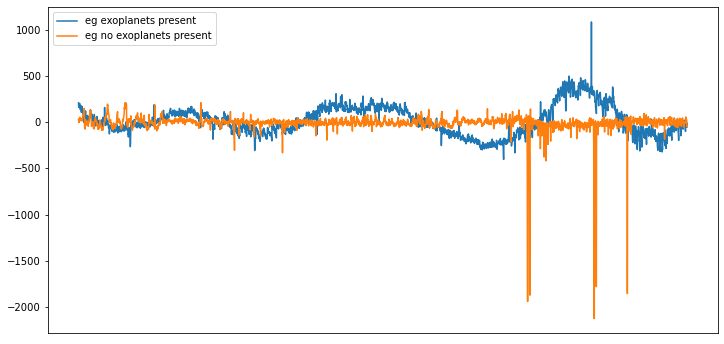

In [10]:
plot_systems(df_train_trans_data)

- clearly visibile sinusodial wave in case of present exoplanet
- in both cases cleary visible outliers which should be adressed
- flux values have different magnitudes

## Machine Learning Model
### Baseline Models
- First check the difficulty of the problem with a couple of baseline models
    - No further preprocessing or hyperparameter tuning
    - Simple accracy score
- Split train data into train and validation data
    - For hyperparameter tuning I will use cross-validation instead
- Filter data
- Scale data with standard scaler
- Use periodogram instead of features

In [11]:
#Split into train and validate data
X = df_train.iloc[:, 1:].values
y = df_train.iloc[:, :1].values
y = y.reshape(y.shape[0])

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, stratify=y, random_state=1234)

In [12]:
print(f'Samples in trainings data:\t{X_train.shape[0]}')
print(f'Samples in validation data:\t{X_val.shape[0]}')

Samples in trainings data:	4069
Samples in validation data:	1018


In [59]:
#function to evaluate baseline models
def base_models(X_train, X_test, y_train, y_test):
    #list of baseline models
    model_names = ["Logistic_Regression", "Random_Forest", "AdaBoost", "KNN", "Linear_SVC", "Naive_Bayes"]

    model_list = [LogisticRegression()
               , RandomForestClassifier()
               , AdaBoostClassifier()
               , KNeighborsClassifier()
               , SVC(kernel="linear")
               , GaussianNB()]  
    
    #evaluate all models
    for i, model in enumerate(model_list):
        start = timer()
        model.fit(X_train, y_train)
        print(f'Model: {model_names[i]}')
        print(f'Trainings  Score:\t{model.score(X_train, y_train):0.10f}')
        print(f'Validation Score:\t{model.score(X_test, y_test):0.10f}')
        end = timer()
        print(f'Elapsed Time:\t{end - start:0.4f}s\n')

In [14]:
#baseline on untreated data
base_models(X_train, X_val, y_train, y_val)

/home/clemens/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model: Logistic_Regression
Trainings  Score:	0.708036
Validation Score:	0.640472
Elapsed Time:	2.37s

Model: Random_Forest
Trainings  Score:	1.000000
Validation Score:	0.993124
Elapsed Time:	8.47s

Model: AdaBoost
Trainings  Score:	1.000000
Validation Score:	0.992141
Elapsed Time:	73.10s

Model: KNN
Trainings  Score:	0.992627
Validation Score:	0.993124
Elapsed Time:	109.92s

Model: Linear_SVC
Trainings  Score:	1.000000
Validation Score:	0.961690
Elapsed Time:	21.80s

Model: Naive_Bayes
Trainings  Score:	0.032932
Validation Score:	0.025540
Elapsed Time:	0.41s



- All models (except naive bayes and Log Regression) show very good results
- KNN and AdaBoost take to long to train
- Random Forest has highest accuracy while being resonable fast to train
- Next step is to improve perfomance of random forest further by tweaking the hyperparameters and preprocessing

#### Baseline on Filtered data
I used Wiener Filter

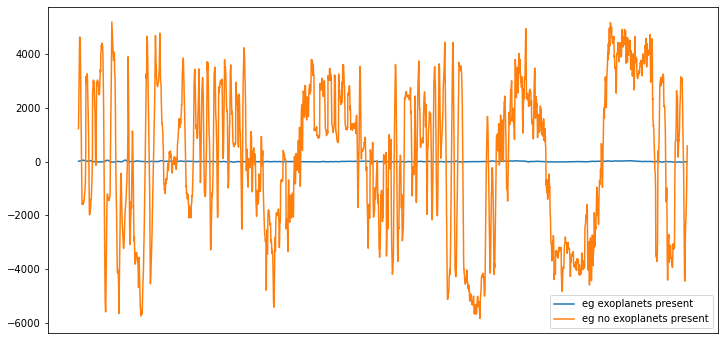

In [15]:
#Filter input
X_train_filtered = wiener(X_train, mysize=15)
X_val_filtered = wiener(X_val, mysize=15)
plot_systems(X_train_filtered)

In [16]:
base_models(X_train_filtered, X_val_filtered, y_train, y_val)

/home/clemens/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model: Logistic_Regression
Trainings  Score:	0.874662
Validation Score:	0.617878
Elapsed Time:	2.28s

Model: Random_Forest
Trainings  Score:	1.000000
Validation Score:	0.993124
Elapsed Time:	9.60s

Model: AdaBoost
Trainings  Score:	0.995085
Validation Score:	0.990177
Elapsed Time:	71.23s

Model: KNN
Trainings  Score:	0.992627
Validation Score:	0.993124
Elapsed Time:	51.50s

Model: Linear_SVC
Trainings  Score:	0.989187
Validation Score:	0.665029
Elapsed Time:	20.16s

Model: Naive_Bayes
Trainings  Score:	0.049889
Validation Score:	0.039293
Elapsed Time:	0.39s



- Performance of SVC drops
- Performance of Log Regression drops slightly
- Performance of other models does not change

#### Baseline on scaled data
Use Standard Scaler

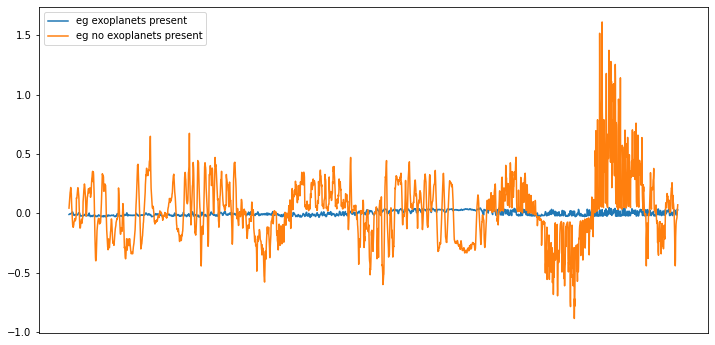

In [17]:
#scale input
std_scaler = StandardScaler()
std_scaler.fit(X_train_filtered)
X_train_scaled = std_scaler.transform(X_train_filtered)
X_val_scaled = std_scaler.transform(X_val_filtered)
plot_systems(X_train_scaled)

In [18]:
base_models(X_train_scaled, X_val_scaled, y_train, y_val)

/home/clemens/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model: Logistic_Regression
Trainings  Score:	0.992627
Validation Score:	0.991159
Elapsed Time:	2.03s

Model: Random_Forest
Trainings  Score:	1.000000
Validation Score:	0.993124
Elapsed Time:	9.46s

Model: AdaBoost
Trainings  Score:	0.995085
Validation Score:	0.990177
Elapsed Time:	70.72s

Model: KNN
Trainings  Score:	0.992627
Validation Score:	0.993124
Elapsed Time:	52.10s

Model: Linear_SVC
Trainings  Score:	0.992873
Validation Score:	0.992141
Elapsed Time:	6.62s

Model: Naive_Bayes
Trainings  Score:	0.049889
Validation Score:	0.039293
Elapsed Time:	0.37s



- Scaling increases performance of Log Regression and SVC
- Other models are not affected
#### Baseline on Periodogram

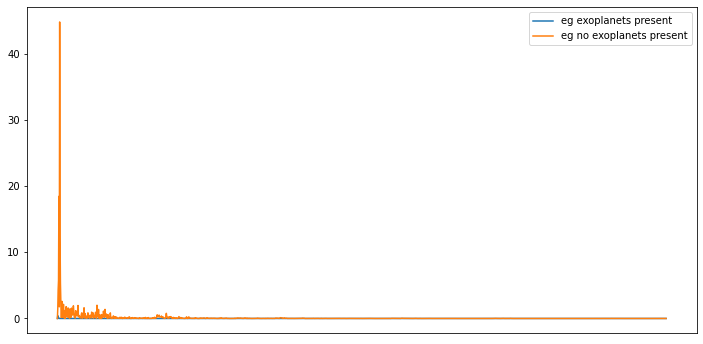

In [42]:
#Calc periodogram
_, X_train_period = periodogram(X_train_scaled)
_, X_val_period = periodogram(X_val_scaled)
plot_systems(X_train_period)

In [20]:
base_models(X_train_period, X_val_period, y_train, y_val)

/home/clemens/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model: Logistic_Regression
Trainings  Score:	0.992627
Validation Score:	0.993124
Elapsed Time:	0.44s

Model: Random_Forest
Trainings  Score:	1.000000
Validation Score:	0.993124
Elapsed Time:	7.69s

Model: AdaBoost
Trainings  Score:	0.996314
Validation Score:	0.993124
Elapsed Time:	29.69s

Model: KNN
Trainings  Score:	0.992627
Validation Score:	0.993124
Elapsed Time:	11.05s

Model: Linear_SVC
Trainings  Score:	0.992873
Validation Score:	0.993124
Elapsed Time:	4.70s

Model: Naive_Bayes
Trainings  Score:	0.018432
Validation Score:	0.009823
Elapsed Time:	0.27s



- Naive Bayes performs worse
- Other models are not affected
#### Baseline with PCA
- Should improve performance
- 1000 is just a guess will be imprived later with grid and random search

In [57]:
#reduce features with PCA
pca = PCA(n_components=1000)
pca.fit(X_train_period)
X_train_pca = pca.transform(X_train_period)
X_val_pca = pca.transform(X_val_period)

In [58]:
base_models(X_train_pca, X_val_pca, y_train, y_val)

Model: Logistic_Regression
Trainings  Score:	0.992627
Validation Score:	0.993124
Elapsed Time:	0.16s

Model: Random_Forest
Trainings  Score:	0.996805
Validation Score:	0.990177
Elapsed Time:	9.46s

Model: AdaBoost
Trainings  Score:	0.994102
Validation Score:	0.980354
Elapsed Time:	16.74s

Model: KNN
Trainings  Score:	0.992627
Validation Score:	0.993124
Elapsed Time:	6.95s

Model: Linear_SVC
Trainings  Score:	0.992627
Validation Score:	0.993124
Elapsed Time:	0.71s

Model: Naive_Bayes
Trainings  Score:	0.036864
Validation Score:	0.038310
Elapsed Time:	0.11s



- implement pipeline with all preprocessing steps
- use LogRegression seems to show good performance and is fast

### Custom transformer classes for pipeline

In [67]:
#Transformer class for Filter
class WienerFilter(BaseEstimator, TransformerMixin):
    def __init__(self, mysize=15, noise=None):
        self.mysize = mysize
        self.noise = noise
    
    #There is nothing happening in the fit function
    def fit(self, X, y = None):
        return self
    
    #transform data
    def transform(self, X, y = None):
        return wiener(X, mysize=self.mysize, noise=self.noise)
    
    
#Transformer class for periodogramm
class Periodogram(BaseEstimator, TransformerMixin):
    def __init__(self, fs=1.0, window='boxcar', nfft=None, detrend='constant', scaling='density'):
        self.fs = fs
        self.window = window
        self.nfft = nfft
        self.detrend = detrend
        self.scaling = scaling
    
    #There is nothing happening in the fit function
    def fit(self, X, y = None):
        return self
    
    #transform data
    def transform(self, X, y = None):
        _, X_period = periodogram(X, fs=self.fs, window=self.window, nfft=self.nfft,
                                  detrend=self.detrend, scaling=self.scaling)
        return X_period

### Logistic Regression Classifier
#### Pipeline for all steps

In [68]:
logreg_pipe = Pipeline(steps=[
                         ('wiener_filter', WienerFilter())
                        ,('std_scaler', StandardScaler())
                        ,('periodogram', Periodogram())
                        ,('pca', PCA(n_components=1000))
                        ,('log_regression', LogisticRegression())
                         ])

In [70]:
#lists of hyperparameters to tune
random_params = {'pca__n_components': [1000, 750, 500, 250, 100]
                , 'log_regression__C' : [0.001, 0.01, 0.1, 1, 10]
                , 'log_regression__max_iter' : [100, 200, 500, 1000]
                , 'log_regression__fit_intercept' : [True, False]
                }

In [76]:
#random search
logpipe_random_cv = RandomizedSearchCV(logreg_pipe, param_distributions=random_params,
                                      n_iter=100, cv=5, n_jobs=-1, verbose=10, random_state=4321)
logpipe_random_cv.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('wiener_filter', WienerFilter()),
                                             ('std_scaler', StandardScaler()),
                                             ('periodogram', Periodogram()),
                                             ('pca', PCA(n_components=1000)),
                                             ('log_regression',
                                              LogisticRegression())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'log_regression__C': [0.001, 0.01, 0.1,
                                                              1, 10],
                                        'log_regression__fit_intercept': [True,
                                                                          False],
                                        'log_regression__max_iter': [100, 200,
                                                                     500,
                   

In [77]:
print(f'Training Score:\t{logpipe_random_cv.score(X_train, y_train)}')
print(f'Validate Score:\t{logpipe_random_cv.score(X_val, y_val)}')
print(f'Best model: {logpipe_random_cv.best_params_}')

y_val_predicted = logpipe_random_cv.best_estimator_.predict(X_val)
print(f'Confusion Matrix:\n{confusion_matrix(y_val, y_val_predicted)}')
print(f'Classification report:\n{classification_report(y_val, y_val_predicted)}')

Training Score:	0.13295650036864096
Validate Score:	0.09233791748526522
Best model: {'pca__n_components': None, 'log_regression__max_iter': 100, 'log_regression__fit_intercept': True, 'log_regression__C': 0.001}
Confusion Matrix:
[[ 89 922]
 [  2   5]]
Classification report:
              precision    recall  f1-score   support

       False       0.98      0.09      0.16      1011
        True       0.01      0.71      0.01         7

    accuracy                           0.09      1018
   macro avg       0.49      0.40      0.09      1018
weighted avg       0.97      0.09      0.16      1018



#### Hyperparameter tuning with Random Search
Tune for
- Estimators
- max depth
- min leafs
- max features
- criterion

In [21]:
#lists of hyperparameters to tune
random_params = {'criterion': ['entropy', 'gini']
                , 'max_depth' : [10, 100, 1000, None]
                ,'n_estimators' : [50, 100, 200, 500]
                , 'min_samples_leaf' : [1, 5, 10]
                , 'min_samples_split': [5, 10, 15]
                , 'max_features' : ['auto', 'log2']}

#random search
forest_random_cv = RandomizedSearchCV(RandomForestClassifier(), param_distributions=random_params,
                                      n_iter=50, cv=3, n_jobs=-1, verbose=10, random_state=4321)
forest_random_cv.fit(X_train_period, y_train)

print(f'Training Score:\t{forest_random_cv.score(X_train_period, y_train)}')
print(f'Validate Score:\t{forest_random_cv.score(X_val_period, y_val)}')
print(f'Best model: {forest_random_cv.best_params_}')

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.0min


KeyboardInterrupt: 

In [ ]:
y_val_predicted = forest_random_cv.best_estimator_.predict(X_val_period)
print(confusion_matrix(y_val, y_val_predicted))
print(classification_report(y_val, y_val_predicted))
print(accuracy_score(y_val, y_val_predicted))

In [ ]:
#lists of hyperparameters to tune
grid_params = {'criterion': [forest_random_cv.best_params_['criterion']]
                , 'max_features' : [forest_random_cv.best_params_['max_features']]
                ,'n_estimators' : [forest_random_cv.best_params_['n_estimators']]                   
                , 'max_depth' : [forest_random_cv.best_params_['max_depth'] - 5
                                , forest_random_cv.best_params_['max_depth']
                                , forest_random_cv.best_params_['max_depth'] + 5]
                , 'min_samples_leaf' : [forest_random_cv.best_params_['min_samples_leaf'] - 2
                                       , forest_random_cv.best_params_['min_samples_leaf']
                                       , forest_random_cv.best_params_['min_samples_leaf'] + 2]
                , 'min_samples_split': [forest_random_cv.best_params_['min_samples_split'] - 3
                                       , forest_random_cv.best_params_['min_samples_split']
                                       , forest_random_cv.best_params_['min_samples_split'] + 3]
              }

#grid search
forest_grid_cv = GridSearchCV(RandomForestClassifier(), param_grid=grid_params, cv=3, n_jobs=-1, verbose=10)
forest_grid_cv.fit(X_train_period, y_train)

print(f'Training Score:\t{forest_grid_cv.score(X_train_period, y_train)}')
print(f'Validate Score:\t{forest_grid_cv.score(X_val_period, y_val)}')
print(f'Best model: {forest_grid_cv.best_params_}')

In [ ]:
y_val_predicted = forest_grid_cv.best_estimator_.predict(X_val_period)
print(confusion_matrix(y_val, y_val_predicted))
print(classification_report(y_val, y_val_predicted))
print(accuracy_score(y_val, y_val_predicted))

- Apperantly there are no changes if I change imput...